In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import torch
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler 
from PIL import Image
from sklearn.metrics import confusion_matrix , classification_report

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from keras.applications import VGG19
from keras.applications import ResNet50

In [ ]:
#Dataset used: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000
path='/content/drive/MyDrive/hmnist_28_28_RGB.csv'
df = pd.read_csv(path)
df.tail()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0
10014,175,142,121,181,150,134,181,150,133,178,...,159,79,82,174,137,125,175,139,126,6


In [ ]:
fractions=np.array([0.8,0.2])
df=df.sample(frac=1)
train_set, test_set = np.array_split(df, (fractions[:-1].cumsum() * len(df)).astype(int))

In [ ]:
# reference: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/discussion/183083
classes={0:('akiec', 'actinic keratoses and intraepithelial carcinomae'),
         1:('bcc' , 'basal cell carcinoma'),
         2:('bkl', 'benign keratosis-like lesions'),
         3:('df', 'dermatofibroma'),
         4:('nv', ' melanocytic nevi'),
         5:('vasc', ' pyogenic granulomas and hemorrhage'),
         6:('mel', 'melanoma'),}
len(classes)

7

In [ ]:
x_train = train_set.drop(columns=['label'])
y_train = train_set['label']

x_test = test_set.drop(columns=['label'])
y_test = test_set['label']

columns = list(x_train)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


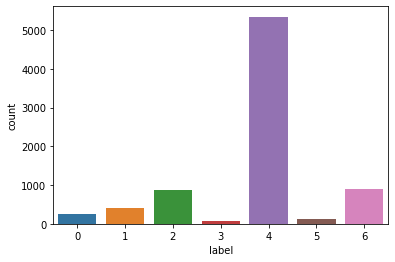

In [ ]:
sns.countplot(train_set['label'])

In [ ]:
len(y_train)

8012

In [ ]:
oversample = RandomOverSampler()
x_train,y_train  = oversample.fit_resample(x_train,y_train) 


In [ ]:
len(y_train)

37443

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


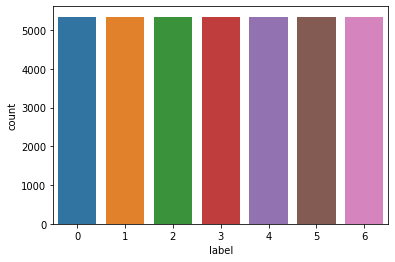

In [ ]:
sns.countplot(y_train)

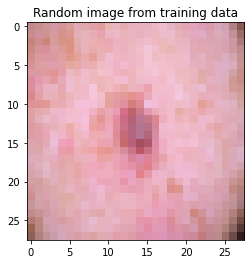

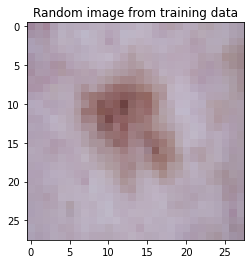

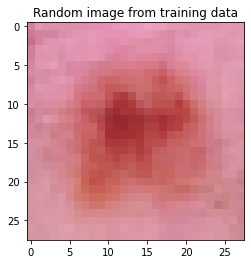

In [ ]:
num=random.randint(0,8000)
x_train=np.array(x_train, dtype=np.uint8).reshape(-1,28,28,3)
x_test=np.array(x_test, dtype=np.uint8).reshape(-1,28,28,3)

plt.imshow(x_train[num].reshape(28,28,3))
plt.title("Random image from training data")
plt.show()

num=random.randint(0,8000)
plt.imshow(x_train[num].reshape(28,28,3))
plt.title("Random image from training data")
plt.show()

num=random.randint(0,8000)
plt.imshow(x_train[num].reshape(28,28,3))
plt.title("Random image from training data")
plt.show()

In [ ]:
def resize_img(images, new_size):
  x_train_copy = []
  i = 0
  while(i < len(images)):
    img28 = Image.fromarray(images[i], 'RGB')
    img32 = img28.resize((new_size, new_size))
    img32arr = np.asarray(img32)
    x_train_copy.append(img32arr)
    i+=1
  x_train_copy = np.array(x_train_copy, dtype=np.uint8).reshape(-1,32,32,3)
  return x_train_copy

x_train = resize_img(x_train, 32)
x_test = resize_img(x_test, 32)

In [ ]:
x_train.shape, x_test.shape

((37443, 32, 32, 3), (2003, 32, 32, 3))

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [32, 32]

# add preprocessing layer to the front of VGG
# vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
resnet = ResNet50(input_shape=(32,32,3), weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet.layers:
  layer.trainable = False


# useful for getting number of classes
# folders = glob('Datasets/Train/*')


# our layers - you can add more if you want
x = Flatten()(resnet.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(classes), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

# view the structure of the model
model.summary()


#reference: https://www.kaggle.com/dhruv1234/ham10000-skin-disease-classification
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/ResNet50/jan_11/val_acc: {val_accuracy:.05f}-val_loss: {val_loss:.05f}-epoch: {epoch:02d}.h5",
    monitor='val_accuracy', mode='max',
    verbose=1, 
    save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

# tell the model what cost and optimization method to use
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = optimizer,
              metrics = ['accuracy'])


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [ ]:
history = model.fit(x_train,
                    y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 200,
                    shuffle=True,
                    callbacks=[callback])

Epoch 1/200
234/235 [============================>.] - ETA: 0s - loss: 1.1294 - accuracy: 0.6266
Epoch 1: val_accuracy improved from -inf to 0.46575, saving model to /content/drive/MyDrive/ResNet50/jan_11/val_acc: 0.46575-val_loss: 1.58485-epoch: 01.h5
235/235 [==============================] - 10s 29ms/step - loss: 1.1294 - accuracy: 0.6266 - val_loss: 1.5848 - val_accuracy: 0.4657
Epoch 2/200
232/235 [============================>.] - ETA: 0s - loss: 0.5919 - accuracy: 0.8172
Epoch 2: val_accuracy improved from 0.46575 to 0.49459, saving model to /content/drive/MyDrive/ResNet50/jan_11/val_acc: 0.49459-val_loss: 1.49132-epoch: 02.h5
235/235 [==============================] - 6s 24ms/step - loss: 0.5911 - accuracy: 0.8177 - val_loss: 1.4913 - val_accuracy: 0.4946
Epoch 3/200
235/235 [==============================] - ETA: 0s - loss: 0.4609 - accuracy: 0.8638
Epoch 3: val_accuracy improved from 0.49459 to 0.81987, saving model to /content/drive/MyDrive/ResNet50/jan_11/val_acc: 0.81987-v

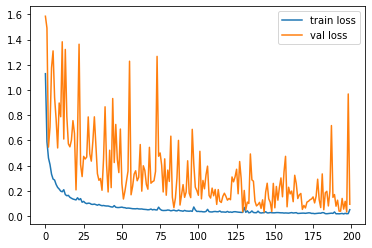

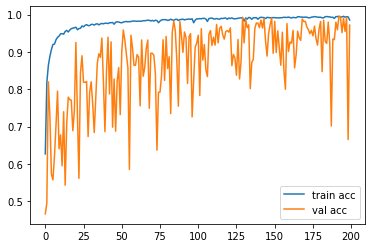

<Figure size 432x288 with 0 Axes>

In [ ]:

# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


In [ ]:
model.load_weights('/content/drive/MyDrive/ResNet50/jan_11/best_model_epoch:200.h5')

print(model.evaluate(x_test, y_test,  verbose=2))

y_preds = model.predict(x_test)
y_preds = np.round(y_preds)

63/63 - 1s - loss: 1.0783 - accuracy: 0.9231 - 763ms/epoch - 12ms/step
[1.0782629251480103, 0.9231153130531311]
63/63 [==============================] - 1s 10ms/step


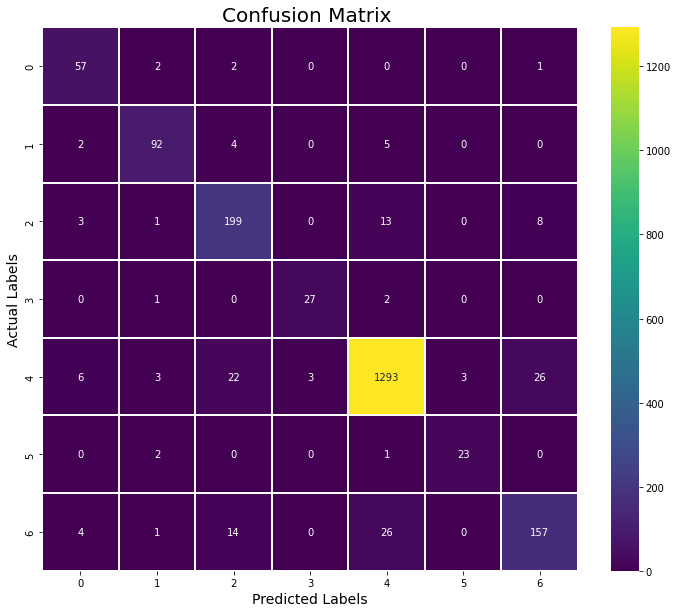

Classification Report 
               precision    recall  f1-score   support

           0       0.79      0.92      0.85        62
           1       0.90      0.89      0.90       103
           2       0.83      0.89      0.86       224
           3       0.90      0.90      0.90        30
           4       0.96      0.95      0.96      1356
           5       0.88      0.88      0.88        26
           6       0.82      0.78      0.80       202

    accuracy                           0.92      2003
   macro avg       0.87      0.89      0.88      2003
weighted avg       0.92      0.92      0.92      2003



In [ ]:
def cnf_matrix(y_actual,y_pred,name):
  cm = confusion_matrix(y_actual, y_pred)
  plt.figure(figsize = (12, 10))
  # cm = pd.DataFrame(cm , index = [i for i in class_arr] , columns = [i for i in class_arr])
  sns.heatmap(cm, linecolor='white', cmap='viridis', linewidth=1, annot=True, fmt='')
  plt.title('Confusion Matrix '+name, size=20)
  plt.xlabel('Predicted Labels', size=14)
  plt.ylabel('Actual Labels', size=14)
  plt.show()
  print("Classification Report \n",classification_report(y_actual, y_pred)) 

cnf_matrix(y_test, np.argmax(y_preds, axis=1), "")